# COVID Tweets - Database Assignment
#### April 16th, 2021 

##### By Hudson Ukass and Justin Przybliski

Notes: 

In [165]:
import sklearn as sk
import os
import pandas as pd
import numpy as np
from pandas import DataFrame
import altair as alt
import spacy as sp
import matplotlib.pyplot as plt
os.chdir('/Users/hudso/OneDrive/Documents/COMP 4522/COVIDTweets-Machine-Learning')
sp.load('en_core_web_sm')

#Covid Tweets dataset
covidTweets = pd.read_csv("vaccination_all_tweets.csv")
#Covid Cases Data
#https://www.kaggle.com/gauravduttakiit/covid-19
covidCases = pd.read_csv("worldwide-aggregate.csv")

#Datetime conversions and hour/min/sec rounding 
#for covidTweets and CovidCases df's.
covidTweets["user_created"] = pd.to_datetime(covidTweets["user_created"], errors='coerce').dt.date
covidTweets["date"] = pd.to_datetime(covidTweets["date"], errors='coerce').dt.date
covidCases["Date"] = pd.to_datetime(covidCases["Date"], errors='coerce').dt.date
#covidTweets = covidTweets.assign(date=covidTweets.date.dt.round('D'))

#Drop null and irellevant columns about user profiles 
tweetCase = covidTweets.drop(columns=['user_location', 'user_description', 'user_created', 'hashtags', 'source'])

#Merge the covidTweets and covidCases on their dates.
tweetCase = pd.merge(left=tweetCase, right=covidCases, how='left', left_on='date', 
                  right_on='Date')
tweetCase = tweetCase.drop(columns='Date')
tweetCase = tweetCase.sort_values(by='date', ascending=True)

#Tweet count and covid case stats by day
tweetsDay = tweetCase.groupby('date').count()
tweetsDay = tweetsDay.loc[:,'id']
tweetsDay = tweetsDay.rename('tweet_count')
tweetsDay = pd.merge(left=tweetsDay, right=covidCases, how='left', left_on='date', 
                  right_on='Date')
tweetsDay = tweetsDay.dropna(axis=0)

#covidTweets.head()
#covidCases.head()
#tweetCase.shape
tweetsDay.tail()

,tweet_count,Date,Confirmed,Recovered,Deaths,Increase rate
117,1980,2021-04-08,133943335.0,76113059.0,2901995.0,0.630975
118,1225,2021-04-09,134691380.0,76508889.0,2915400.0,0.558479
119,985,2021-04-10,135355885.0,76891123.0,2927807.0,0.493354
120,877,2021-04-11,136046624.0,77419350.0,2936364.0,0.510313
121,2022,2021-04-12,136500769.0,77714141.0,2944771.0,0.333816


# Machine Learning - Linear Regression
With help of Kaggle Tutorial


In [54]:
#Define the parameters of X and y here. 
covidN = covidTweets.dropna()

#Prediction target
y = covidN.retweets

#Prediction criteria 
covid_features = ['user_friends', 'user_followers', 'user_favourites', 
                    'favorites']
X = covidN[covid_features]
X.head()

,user_friends,user_followers,user_favourites,favorites
0,1692,405,3247,0
2,88,10,155,0
6,5001,2731,69344,4
9,2368,671,20469,0
10,78,1302,339,0


In [55]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.tree import DecisionTreeRegressor
covid_model = DecisionTreeRegressor()
covid_model.fit(X, y)

predicted_retweets = covid_model.predict(X)
mean_absolute_error(y, predicted_retweets)

#In-Sample Scoring
print("Making retweet predictions for the following 5 Tweets:")
print(X.head())
print("The retweet predictions are")
print(covid_model.predict(X.head()))

Making retweet predictions for the following 5 Tweets:
    user_friends  user_followers  user_favourites  favorites
0           1692             405             3247          0
2             88              10              155          0
6           5001            2731            69344          4
9           2368             671            20469          0
10            78            1302              339          0
The retweet predictions are
[0. 0. 0. 0. 0.]


In [56]:
from sklearn.metrics import mean_absolute_error
from sklearn.tree import DecisionTreeRegressor

#Out-of-Sample Scoring 
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state = 0)

covid_model = DecisionTreeRegressor()
covid_model.fit(train_X, train_y)

val_predictions = covid_model.predict(val_X)
#Print the degree of error for out-of-sample
print("General Degree of Error: ", mean_absolute_error(val_y, val_predictions))

def get_mae(max_leaf_nodes, train_X, val_X, train_y, val_y):
    model = DecisionTreeRegressor(max_leaf_nodes=max_leaf_nodes, random_state=0)
    model.fit(train_X, train_y)
    preds_val = model.predict(val_X)
    mae = mean_absolute_error(val_y, preds_val)
    return(mae)
# compare MAE with differing values of max_leaf_nodes
for max_leaf_nodes in [5, 50, 500, 5000, 50000]:
    my_mae = get_mae(max_leaf_nodes, train_X, val_X, train_y, val_y)
    print("Max leaf nodes: %d  \t\t Mean Absolute Error:  %d" %(max_leaf_nodes, my_mae))

General Degree of Error:  2.7704736698118886
Max leaf nodes: 5  		 Mean Absolute Error:  4
Max leaf nodes: 50  		 Mean Absolute Error:  2
Max leaf nodes: 500  		 Mean Absolute Error:  2
Max leaf nodes: 5000  		 Mean Absolute Error:  2
Max leaf nodes: 50000  		 Mean Absolute Error:  2


### Optimal number of leaves is: 50

In [57]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

forest_model = RandomForestRegressor(random_state=1)
forest_model.fit(train_X, train_y)
melb_preds = forest_model.predict(val_X)
print(mean_absolute_error(val_y, melb_preds))

2.2545510049952404


In [58]:
X = covidN.loc[:,['user_friends', 'user_followers', 'user_favourites', 
                    'favorites']].values
y = covidN.retweets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
# Feature Scaling
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

regressor = RandomForestRegressor(n_estimators=50, random_state=1)
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)

from sklearn import metrics

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 2.3730625760501454
Mean Squared Error: 494.90409089560205
Root Mean Squared Error: 22.246439960038597


In [102]:
covidN.retweets.describe()

count    29971.000000
mean         3.868206
std         58.872228
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max       7695.000000
Name: retweets, dtype: float64

177.85870967741934


Validation MAE when not specifying max_leaf_nodes: 252
Validation MAE for best value of max_leaf_nodes: 247


Model Accuracy: 0.6046436040181353


In [111]:
# decision tree for feature importance on a regression problem
from sklearn.datasets import make_regression
from sklearn.tree import DecisionTreeRegressor
from matplotlib import pyplot
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Choose target and features

y = tweetsDay.tweet_count
tweetsDay_features = ['Confirmed','Recovered','Deaths','Increase rate']
X = tweetsDay[tweetsDay_features]


# split data into training and validation data, for both features and target
# The split is based on a random number generator. Supplying a numeric value to
# the random_state argument guarantees we get the same split every time we
# run this script.
train_X, val_X, train_y, val_y = train_test_split(X, y,random_state = 0)

forest_model = RandomForestRegressor(random_state=1)
forest_model.fit(train_X, train_y)
melb_preds = forest_model.predict(val_X)
print(mean_absolute_error(val_y, melb_preds))

# Split into validation and training data
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=1)

# Specify Model
tweet_model = DecisionTreeRegressor(random_state=1)
# Fit Model
tweet_model.fit(train_X, train_y)

# Make validation predictions and calculate mean absolute error
val_predictions = tweet_model.predict(val_X)
val_mae = mean_absolute_error(val_predictions, val_y)
print("Validation MAE when not specifying max_leaf_nodes: {:,.0f}".format(val_mae))

# Using best value for max_leaf_nodes
tweet_model = DecisionTreeRegressor(max_leaf_nodes=247, random_state=1)
tweet_model.fit(train_X, train_y)
val_predictions = tweet_model.predict(val_X)
val_mae = mean_absolute_error(val_predictions, val_y)
print("Validation MAE for best value of max_leaf_nodes: {:,.0f}".format(val_mae))

print(f'Model Accuracy: {tweet_model.score(X, y)}')

tweet_model.fit(X,y)
importance = tweet_model.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))

177.85870967741934
Validation MAE when not specifying max_leaf_nodes: 252
Validation MAE for best value of max_leaf_nodes: 247
Model Accuracy: 0.6046436040181353
Feature: 0, Score: 0.06905
Feature: 1, Score: 0.08926
Feature: 2, Score: 0.60246
Feature: 3, Score: 0.23922


233212.82971484508


AttributeError: 'AxesSubplot' object has no property 'color'

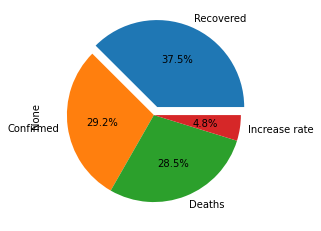

In [174]:
target = 'tweet_count'
features = ['Confirmed','Recovered','Deaths','Increase rate']
train2 = tweetsDay.sample(frac=0.8, random_state=1)
test2 = tweetsDay.loc[~tweetsDay.index.isin(train2.index)]

model = RandomForestRegressor(n_estimators=247, min_samples_leaf=8, random_state=1)

# Fit the model to the data.
model.fit(train2[features], train2[target])
# Make predictions.
predictions_rf = model.predict(test2[features])
# Compute the error.
print(mean_squared_error(predictions_rf, test2[target]))
import matplotlib.ticker as mtick

#plt.ylabel("Impact on Tweet Amount", fontsize = 14)
#plt.xlabel("Global COVID Factors", fontsize = 14)
#plt.ylabel

feat_importances = pd.Series(model.feature_importances_, index=features)

tweetPlot = feat_importances.nlargest().plot(kind='pie', normalize=False, 
                                             explode=(0.1,0,0,0), 
                                             autopct='%1.1f%%')
plt.setp(tweetPlot, **{'color':'white', 'weight':'bold', 'fontsize':12.5})
#tweetPlot.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

tweetPlot.axes.get_xaxis().set_visible(False)
tweetPlot.axes.get_yaxis().set_visible(False)
plt.title("What Covid Factors Influence the Amount of Tweets by Day the Most?\n" + 
          "From 12/12/2020 - 04/12/2021", bbox={'facecolor':'0.8', 'pad':8})

tweetPlot